In [5]:
#!conda install -c conda-forge -c anaconda -y pygraphviz networkx
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


# Class generate jobs

In [168]:
import src.JobGenerator

# Generate Jobs

In [169]:
job_gen = JobGenerator(profiles)
job_gen.generate_variable_dag(duration=60, check_interval=1, arrival_probability=0.3, num_jobs=3)

In [170]:
job_gen.generate_jobs_dataframe()

,id,profile,res,subtime,walltime,dependencies
0,0,med_31,2,16,3373.812240,None
1,1,med_32,2,17,7192.941337,0
2,2,high_41,4,18,11448.753289,1
3,3,med_30,2,16,3319.457489,"0, 1"
4,4,med_30,2,17,3319.457489,None
5,5,high_50,4,18,41468.502385,4
6,6,high_37,4,19,15146.888750,5
7,7,med_20,2,17,2034.229087,"4, 5"
8,8,med_34,2,21,3928.073159,None
9,9,low_3,1,22,629.236217,8


In [171]:
job_gen.generate_jobs_json('workload')

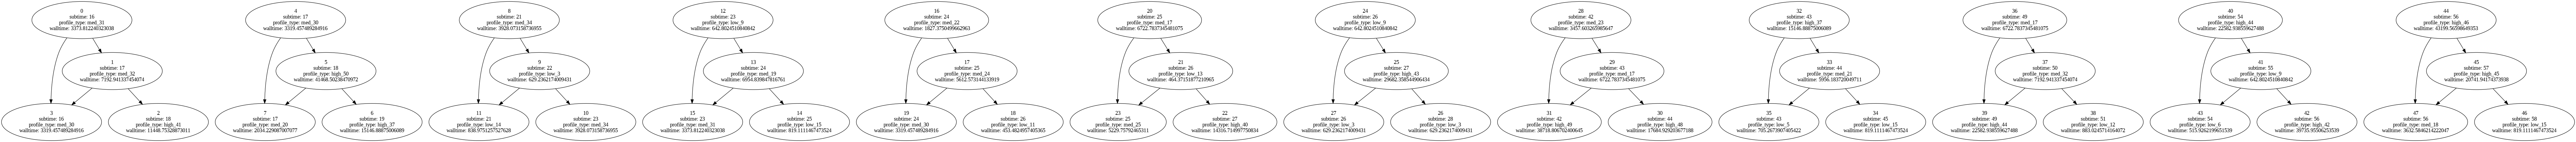

In [172]:
job_gen.visualize_with_subtime_annotations_dot()

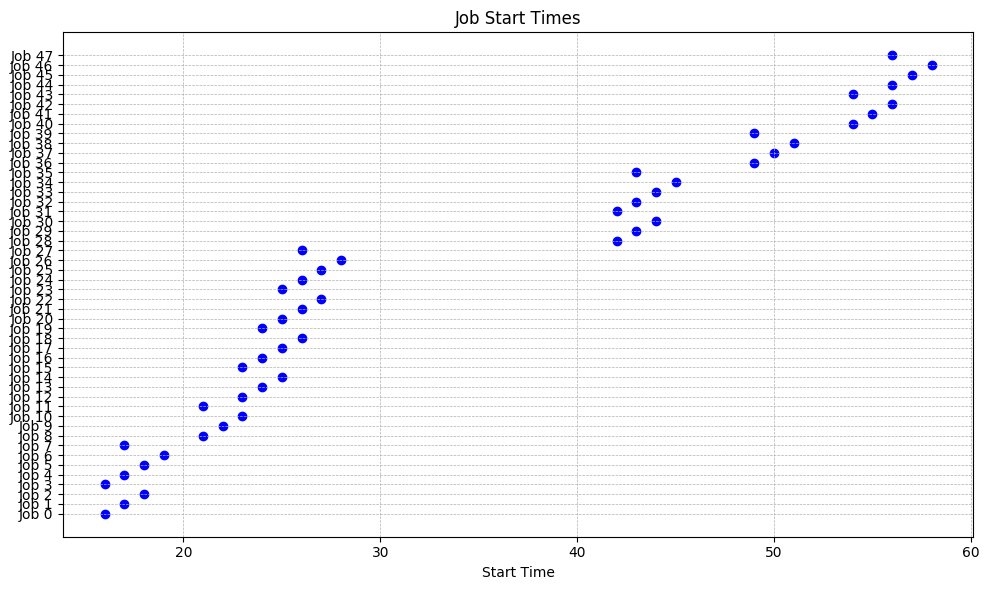

In [173]:
import matplotlib.pyplot as plt
import json

def plot_gantt_chart(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Extrayendo información de los trabajos
    jobs = data['jobs']
    job_ids = [job['id'] for job in jobs]
    start_times = [job['subtime'] for job in jobs]
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(start_times, job_ids, color='blue', marker='o')
    ax.set_yticks(job_ids)
    ax.set_yticklabels(['Job ' + str(i) for i in job_ids])
    ax.set_xlabel('Start Time')
    ax.set_title('Job Start Times')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# Usar la función para mostrar el gráfico de inicio de las tareas
plot_gantt_chart('workload.json')

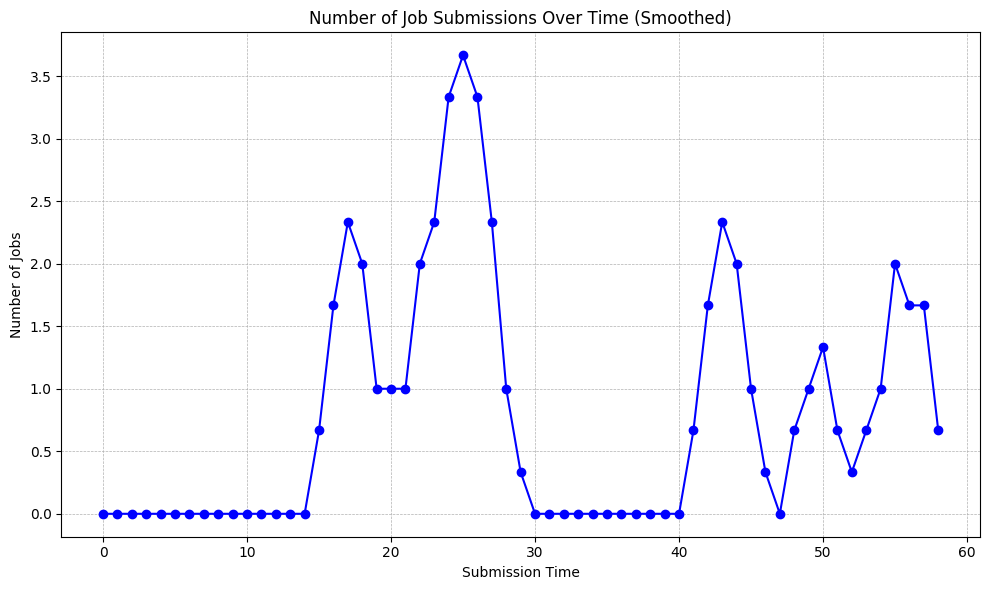

In [174]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated jobs from the JSON
with open("workload.json", "r") as file:
    workload_data = json.load(file)

# Extract subtimes
subtimes = [job["subtime"] for job in workload_data["jobs"]]

# Create a histogram of job counts for intervals of time
time_bins = np.arange(0, max(subtimes) + 2, 1)  # Assuming each bin is of size 1. Adjust if needed.
job_counts, _ = np.histogram(subtimes, bins=time_bins)

# Compute the rolling average
window_size = 3  # This is the number of points considered for the moving average. Adjust as needed.
smoothed_job_counts = np.convolve(job_counts, np.ones(window_size)/window_size, mode='same')

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], smoothed_job_counts, marker='o', linestyle='-', color='b')
plt.title("Number of Job Submissions Over Time (Smoothed)")
plt.xlabel("Submission Time")
plt.ylabel("Number of Jobs")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


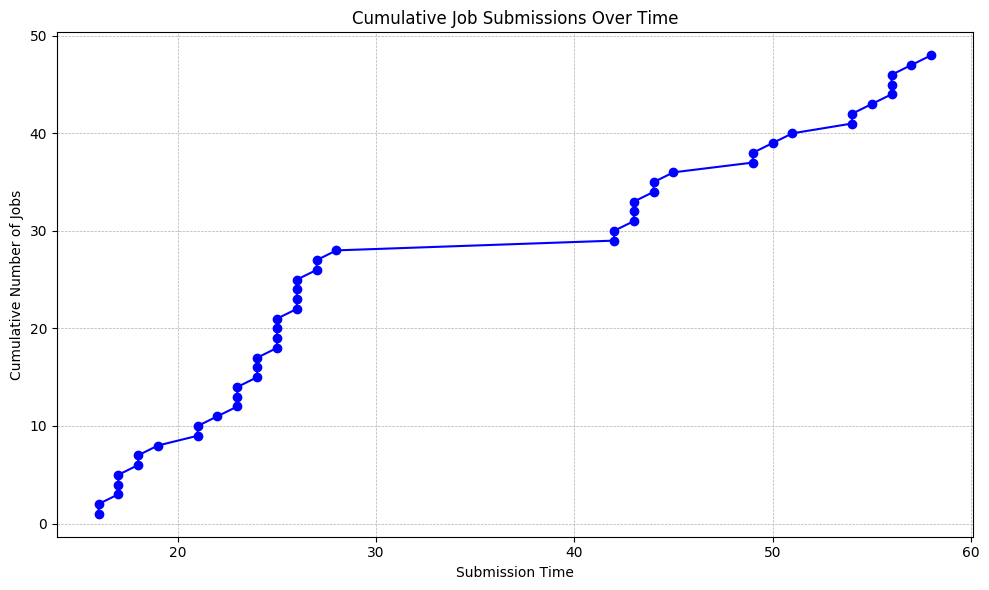

In [175]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated jobs from the JSON
with open("workload.json", "r") as file:
    workload_data = json.load(file)

# Extract subtimes
subtimes = [job["subtime"] for job in workload_data["jobs"]]

# Sorting subtimes
sorted_subtimes = np.sort(subtimes)

# Create a cumulative count of jobs for each unique subtime
cumulative_counts = np.arange(1, len(sorted_subtimes) + 1)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_subtimes, cumulative_counts, marker='o', linestyle='-', color='b')
plt.title("Cumulative Job Submissions Over Time")
plt.xlabel("Submission Time")
plt.ylabel("Cumulative Number of Jobs")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [166]:
!cp workload.json ../../workloads/
!cp workload_dependencies.json ../../workloads/